In [1]:
import numpy as np
import pandas as pd
import pickle
import gzip

# from joblib import Parallel, delayed
# import multiprocessing
from methods.index_helpers import load_Kp
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec

import bisect
from scipy import interpolate


from scipy import stats
from methods.xflib import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable
xf = xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')
from scipy.integrate import nquad

from methods.GLD_file_tools import GLD_file_tools

from methods.precip_model import precip_model, build_database

# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [2]:
# # --- build db ---
# suffix = 'AE8MAX_flux_0' # ae8max,
#suffix = 'AE8MAX_flux_1' # bell model
suffix = 'AE8MAX_flux_2' # propensity
# suffix = 'AE8MIN_flux_0' # ae8minx
nb = 32
for side in ['nightside','dayside']:
    db = build_database(path='../outputs/stencils/%s/stencil_30f_0.2L/'%side,
                        n_bands = nb, avail_kp = [0,2,4,6], suffix=suffix)

    with open('../outputs/precip_dbs/%s_%s_%db.pkl'%(side, suffix, nb),'wb') as file:
        pickle.dump(db, file, protocol=pickle.HIGHEST_PROTOCOL)    
        
print "great success!"

In [3]:
# # --- Precalculate stencils ---

mode = 'energy' #'counts'
logscale = False
unique_kp = [0.,0.3,0.7, 1.,1.3, 1.7, 2.,2.3, 2.7, 3., 3.3, 3.7, 4., 4.3, 4.7,5.,5.3,5.7,6.,]#6.3,6.7,7.,7.3,7.7,8.]
inlats = np.arange(15, 56, 1) 
stencil_lats = np.linspace(-90, 89.5, 360)
stencil_lons = np.linspace(-14, 14, 57)
# print stencil_lats, stencil_lons

with open('../outputs/precip_dbs/nightside_%s_%db.pkl'%(suffix, nb),'rb') as file:
    db = pickle.load(file)
    
    p_night = precip_model(db, mode=mode)
    p_night.precalculate(unique_kp, inlats, stencil_lats, stencil_lons, logscale=logscale)

with open('../outputs/precip_dbs/dayside_%s_%db.pkl'%(suffix, nb),'rb') as file:
    db = pickle.load(file)
    
    p_day = precip_model(db, mode=mode)
    p_day.precalculate(unique_kp, inlats, stencil_lats, stencil_lons, logscale=logscale)

Q_NH Q_SH
7.09437955473e-11 -2.04871877341e-13
multi band interpolators
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
Q_NH Q_SH
9.56437561065e-12 0.0
multi band interpolators
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31


In [4]:
# This is a little bit of a band-aid. Move the precalculated stencils from an ndarray to a dictionary --
# key ~ [kp, inlat], data ~ [outlats, outlons]

precalc_stencils = dict()

for kp_ind, kp in enumerate(unique_kp):
    for inlat_ind, inlat in enumerate(inlats):

        key = (int(np.round(10.*kp)), inlat, 0)
        precalc_stencils[key] = p_night.precalculated['data'][kp_ind, inlat_ind, :,:].squeeze()
#         print np.shape(p_night.precalculated['data'])
#         print np.shape(precalc_stencils[key])


        key = (int(np.round(10.*kp)), inlat, 12)
        precalc_stencils[key] = p_day.precalculated['data'][kp_ind, inlat_ind, :,:].squeeze()

        
print len(precalc_stencils.keys())


1558


In [5]:
# Get Kp data
Ktimes, Kp_arr = load_Kp()
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp_arr = np.array(Kp_arr)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp_arr[0:-8],Kp_arr[1:-7],Kp_arr[2:-6], Kp_arr[3:-5],
                Kp_arr[4:-4],Kp_arr[5:-3],Kp_arr[6:-2], Kp_arr[7:-1], Kp_arr[8:]],axis=0)
Kpmtimes = Ktimes[8:]

unique_Kpm = np.unique(Kpmax)
# print unique_Kpm

In [178]:
data_path = '../../lightning_power_study/outputs/GLDstats_v6/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

cur_map_lats = np.arange(-90, 90)
# stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()

# Set up grid:
gridlons = np.arange(-180, 180, 0.5)
gridlats = np.arange(-90, 90, 0.5)
# pwr_map = np.zeros([len(gridlons), len(gridlats)])



total_files = len(files)

cur_map_total = np.zeros([180, 360])
count=0
counts = dict()



for f_ind, filename in enumerate(files[0:100]):
    print "loading %d/%d"%(f_ind, total_files)
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')
#         print thingy.keys()
        # Get current Kpmax
        Kpm_index = bisect.bisect_left(Kpmtimes, intime)
        Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
        print Kpm
        # Load squared current map:
        cur_map = thingy['cur_map']

        # Inject some fake datapoints to debug:
#         cur_map = np.zeros_like(thingy['cur_map'])
#         cur_map[np.argmin(np.abs(cur_map_lats - 30)), 180] = pow(-10000000,2)
        
#         cur_map[50, 2] = pow(-1000000,2)
        
#         print np.shape(cur_map)


        # Select day and night bins:
        mltvec = xf.lon2MLT(intime, gridlons)
        mltvec_quantized = np.zeros_like(gridlons)
        mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12
          
#         mltvec_quantized = np.digitize(mltvec, [0, 6, 18, 24])
#         print mltvec_quantized
#         plt.figure()
#         plt.plot(gridlons, mltvec_quantized)
        cur_map_total += cur_map
        # Loop through each cell in the input current map, interpolate and add
        todo = np.where(np.abs(cur_map) > 0)
        
        
        outkey = int(np.round(10.*Kpm))        
        if counts.has_key(outkey):
            counts[outkey] += 1
        else:
            counts[outkey] = 1
        
        count += 1
        for x,y in zip(todo[0], todo[1]):
            I = cur_map[x,y] # squared input current
#             print x, y
            # Absolute value on latitude, since we're assuming model is symmetric North / South
            cur_mlt = int(mltvec_quantized[y])
            cur_lat = int(np.abs(np.round(cur_map_lats[x])))
        
            key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
#             print key
#             key = (0, cur_lat, cur_mlt)
    
            # this version to track activity at each Kp
#             outkey = (cur_mlt, int(np.round(10.*Kpm)))
            outkey = cur_mlt
#             # this version to just do average day + night
#             outkey = cur_mlt
            
            if precalc_stencils.has_key(key):
                stencil = precalc_stencils[key].T*I

                # Add to respective map:
                lonleft  = int(y*2 - len(stencil_lons)/2 - 1)
                lonright = int(y*2 + len(stencil_lons)/2)
                
#                 print lonleft, lonright
#                 print gridlons[lonleft], gridlons[lonright]
                
                if not pwr_maps.has_key(outkey):
                    pwr_maps[outkey] = np.zeros([len(gridlons), len(gridlats)])
                if lonleft < 0:
                    # wrap left
                    pwr_maps[outkey][0:lonright,: ]+= stencil[np.abs(lonleft):,:]
                    pwr_maps[outkey][(len(gridlons) - np.abs(lonleft)):,:] += \
                            stencil[0:np.abs(lonleft),:]

                elif lonright > len(gridlons):
                    # wrap right
                    pwr_maps[outkey][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :]
                    pwr_maps[outkey][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:]

                else:
                    # Middle
                    pwr_maps[outkey][lonleft:lonright, :] += stencil

# ax[0].imshow(np.log10(pwr_maps[0]).T, origin='lower', interpolation='none')

pwr_maps_linear = dict()

for k in pwr_maps.keys():
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
#     pwr_maps[k] *= period_factor/counts[k[1]]
#     pwr_maps[k] /= counts[k]   # Average over each 3-hour frame
    pwr_maps[k] /= count   # Average over each 3-hour frame
    pwr_maps[k] /= file_duration  # Total precip -> counts/cm^2/sec
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100


loading 0/3157
2.7


ValueError: non-broadcastable output operand with shape (57,360) doesn't match the broadcast shape (16,57,360)

<IPython.core.display.Javascript object>


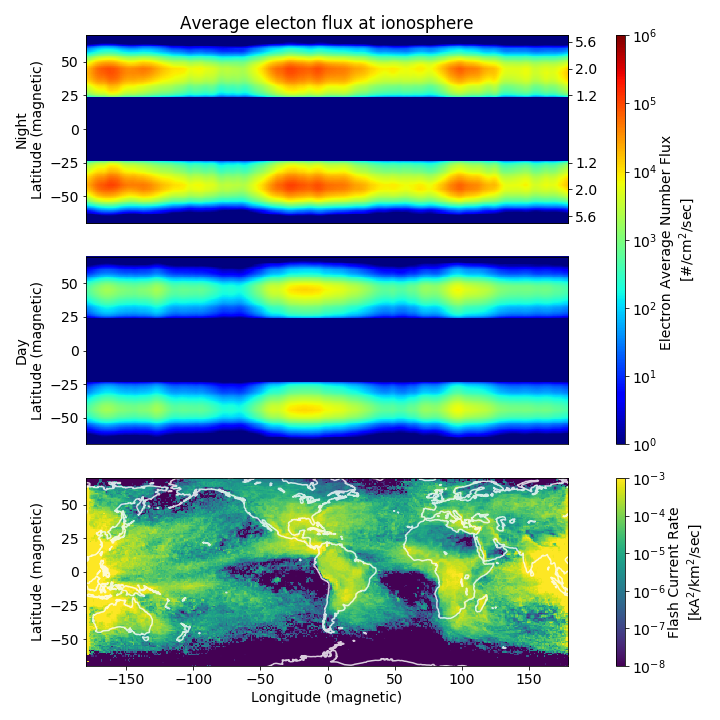

-100.0 5.04234759683


In [164]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(np.arange(-90, 90, 0.5)) + dlat/2.0)*D2R))

# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 9
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [0, 6]


fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])

print np.min(pwr_maps[0]), np.max(pwr_maps[0])
p0 = ax[0].pcolorfast(gridlons, gridlats, pwr_maps[0].T,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
p1 = ax[1].pcolorfast(gridlons, gridlats, pwr_maps[12].T, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
ax[0].set_ylim([-70,70])
ax[1].set_ylim([-70,70])

twinx0 = ax[0].twinx()
twinx0.set_ylim([-70,70])
# twinx0.set_xticks([])
ytix = np.array([-65,-45,-25, 25,45,65])
ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
ytix_L_labels = ['%.1f'%z for z in ytix_L]
twinx0.set_yticks(ytix)
twinx0.set_yticklabels(ytix_L_labels)


# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Electron Average Number Flux \n[#/cm$^2$/sec]') 


cmt = cur_map_total/(f_ind + 1)
cmt /= file_duration
# cmt *= sec_in_year
cmt /= (1000.*1000)
cmt /= cell_areas[np.newaxis,:]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100

clims2 = [-8, -3]
# print np.min(cmt), np.max(cmt)
p3 = ax[2].pcolorfast(np.arange(-180,180), np.arange(-90, 90), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'))
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-70, 70])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 


ax[0].set_xticks([])
ax[0].set_ylabel('Night\nLatitude (magnetic)')
ax[1].set_ylabel('Day\nLatitude (magnetic)')
ax[1].set_xticks([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')

ax[0].set_title('Average electon flux at ionosphere')
gs.tight_layout(fig)

# fig.savefig('Energy_density_daynite.png',dpi=300)

In [157]:
print np.arccos(np.sqrt(1.0/db['L_axis']))*R2D
print db['L_axis']

1.0/pow(np.cos(np.array([24.09484255,  32.31153324,  37.76124391,  41.8103149])*D2R),2)

[ 24.09484255  32.31153324  37.76124391  41.8103149   45.          47.60795429
  49.79703411  51.6711819   53.3007748   54.73561032  56.01215642
  57.15786959  58.19389998  59.13685682  60.          60.79406775
  61.52786558  62.20869436  62.84266736  63.43494882  63.98993622
  64.51140128  65.00260044  65.46636229  65.90515745  66.32115499
  66.71626828  67.09219258  67.45043608]
[ 1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.
  4.2  4.4  4.6  4.8  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8]


array([ 1.2,  1.4,  1.6,  1.8])

#### This version for multiple energy bands:

In [7]:
data_path = '../../lightning_power_study/outputs/GLDstats_v6/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

cur_map_lats = np.arange(-90, 90)
# stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()

# Set up grid:
gridlons = np.arange(-180, 180, 0.5)
gridlats = np.arange(-90, 90, 0.5)
# pwr_map = np.zeros([len(gridlons), len(gridlats)])



total_files = len(files)

cur_map_total = np.zeros([180, 360])
count=0
counts = dict()


n_bands = 32
for f_ind, filename in enumerate(files[0:100]):
    print "loading %d/%d"%(f_ind, total_files)
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')
#         print thingy.keys()
        # Get current Kpmax
        Kpm_index = bisect.bisect_left(Kpmtimes, intime)
        Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
        print Kpm
        # Load squared current map:
        cur_map = thingy['cur_map']

        # Inject some fake datapoints to debug:
#         cur_map = np.zeros_like(thingy['cur_map'])
#         cur_map[np.argmin(np.abs(cur_map_lats - 30)), 180] = pow(-10000000,2)
        
#         cur_map[50, 2] = pow(-1000000,2)
        
#         print np.shape(cur_map)


        # Select day and night bins:
        mltvec = xf.lon2MLT(intime, gridlons)
        mltvec_quantized = np.zeros_like(gridlons)
        mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12
          
#         mltvec_quantized = np.digitize(mltvec, [0, 6, 18, 24])
#         print mltvec_quantized
#         plt.figure()
#         plt.plot(gridlons, mltvec_quantized)
        cur_map_total += cur_map
        # Loop through each cell in the input current map, interpolate and add
        todo = np.where(np.abs(cur_map) > 0)
        
        
        outkey = int(np.round(10.*Kpm))        
        if counts.has_key(outkey):
            counts[outkey] += 1
        else:
            counts[outkey] = 1
        
        count += 1
        for x,y in zip(todo[0], todo[1]):
            I = cur_map[x,y] # squared input current
#             print x, y
            # Absolute value on latitude, since we're assuming model is symmetric North / South
            cur_mlt = int(mltvec_quantized[y])
            cur_lat = int(np.abs(np.round(cur_map_lats[x])))
        
            key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
#             print key
#             key = (0, cur_lat, cur_mlt)
    
            # this version to track activity at each Kp
#             outkey = (cur_mlt, int(np.round(10.*Kpm)))
            outkey = cur_mlt
#             # this version to just do average day + night
#             outkey = cur_mlt
            
            if precalc_stencils.has_key(key):
                stencil = precalc_stencils[key].swapaxes(0,1)*I

                # Add to respective map:
                lonleft  = int(y*2 - len(stencil_lons)/2 - 1)
                lonright = int(y*2 + len(stencil_lons)/2)
                
#                 print lonleft, lonright
#                 print gridlons[lonleft], gridlons[lonright]
                
                if not pwr_maps.has_key(outkey):
                    pwr_maps[outkey] = np.zeros([len(gridlons), len(gridlats), n_bands])
                if lonleft < 0:
                    # wrap left
                    pwr_maps[outkey][0:lonright,: ]+= stencil[np.abs(lonleft):,:,:]
                    pwr_maps[outkey][(len(gridlons) - np.abs(lonleft)):,:,:] += \
                            stencil[0:np.abs(lonleft),:,:]

                elif lonright > len(gridlons):
                    # wrap right
                    pwr_maps[outkey][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :,:]
                    pwr_maps[outkey][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:,:]

                else:
                    # Middle
                    pwr_maps[outkey][lonleft:lonright, :,:] += stencil

# ax[0].imshow(np.log10(pwr_maps[0]).T, origin='lower', interpolation='none')

pwr_maps_linear = dict()

for k in pwr_maps.keys():
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
#     pwr_maps[k] *= period_factor/counts[k[1]]
#     pwr_maps[k] /= counts[k]   # Average over each 3-hour frame
    pwr_maps[k] /= count   # Average over each 3-hour frame
    pwr_maps[k] /= file_duration  # Total precip -> counts/cm^2/sec
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100



loading 0/3157
2.7
loading 1/3157
1.0
loading 2/3157
2.7
loading 3/3157
3.0
loading 4/3157
3.3
loading 5/3157
2.3
loading 6/3157
3.3
loading 7/3157
2.0
loading 8/3157
3.0
loading 9/3157
3.7
loading 10/3157
2.3
loading 11/3157
1.7
loading 12/3157
2.7
loading 13/3157
6.3
loading 14/3157
3.7
loading 15/3157
3.0
loading 16/3157
3.0
loading 17/3157
4.0
loading 18/3157
5.3
loading 19/3157
3.0
loading 20/3157
6.0
loading 21/3157
3.7
loading 22/3157
3.7
loading 23/3157
4.3
loading 24/3157
3.0
loading 25/3157
5.0
loading 26/3157
3.0
loading 27/3157
3.7
loading 28/3157
3.7
loading 29/3157
3.0
loading 30/3157
6.3
loading 31/3157
2.7
loading 32/3157
2.3
loading 33/3157
4.0
loading 34/3157
4.0
loading 35/3157
2.7
loading 36/3157
2.3
loading 37/3157
6.0
loading 38/3157
5.3
loading 39/3157
4.0
loading 40/3157
3.7
loading 41/3157
1.7
loading 42/3157
3.7
loading 43/3157
3.3
loading 44/3157
2.0
loading 45/3157
3.7
loading 46/3157
2.7
loading 47/3157
0.3
loading 48/3157
2.0
loading 49/3157
3.3
loading 50

<IPython.core.display.Javascript object>


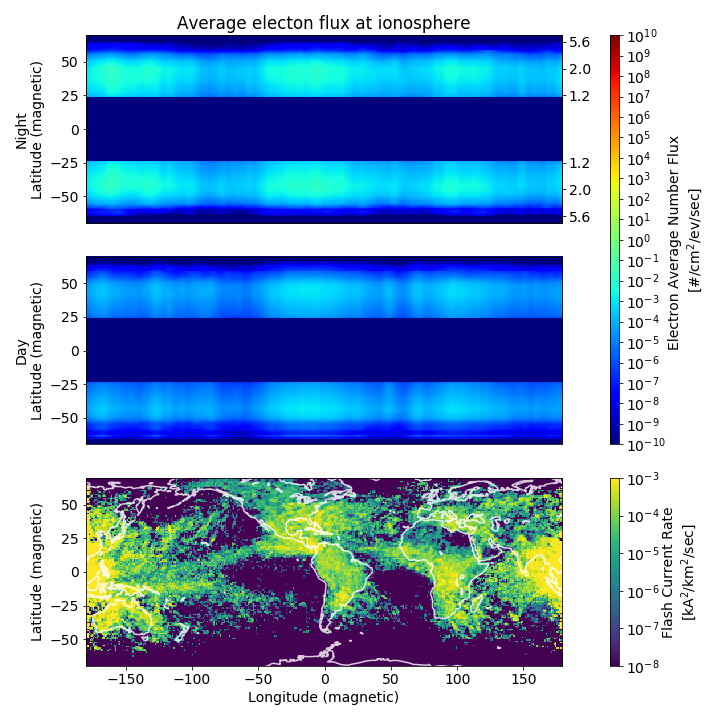

-100.0 -1.65150797138


In [8]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(np.arange(-90, 90, 0.5)) + dlat/2.0)*D2R))

# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 9
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [-10, 10]


band_index = 1

fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])

print np.min(pwr_maps[0]), np.max(pwr_maps[0])
p0 = ax[0].pcolorfast(gridlons, gridlats, pwr_maps[0][:,:,band_index].T,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
p1 = ax[1].pcolorfast(gridlons, gridlats, pwr_maps[12][:,:,band_index].T, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
ax[0].set_ylim([-70,70])
ax[1].set_ylim([-70,70])

twinx0 = ax[0].twinx()
twinx0.set_ylim([-70,70])
# twinx0.set_xticks([])
ytix = np.array([-65,-45,-25, 25,45,65])
ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
ytix_L_labels = ['%.1f'%z for z in ytix_L]
twinx0.set_yticks(ytix)
twinx0.set_yticklabels(ytix_L_labels)


# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Electron Average Number Flux \n[#/cm$^2$/ev/sec]') 


cmt = cur_map_total/(f_ind + 1)
cmt /= file_duration
# cmt *= sec_in_year
cmt /= (1000.*1000)
cmt /= cell_areas[np.newaxis,:]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100

clims2 = [-8, -3]
# print np.min(cmt), np.max(cmt)
p3 = ax[2].pcolorfast(np.arange(-180,180), np.arange(-90, 90), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'))
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-70, 70])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 


ax[0].set_xticks([])
ax[0].set_ylabel('Night\nLatitude (magnetic)')
ax[1].set_ylabel('Day\nLatitude (magnetic)')
ax[1].set_xticks([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')

ax[0].set_title('Average electon flux at ionosphere')
gs.tight_layout(fig)

# fig.savefig('Energy_density_daynite.png',dpi=300)

(720, 360, 32)


<IPython.core.display.Javascript object>


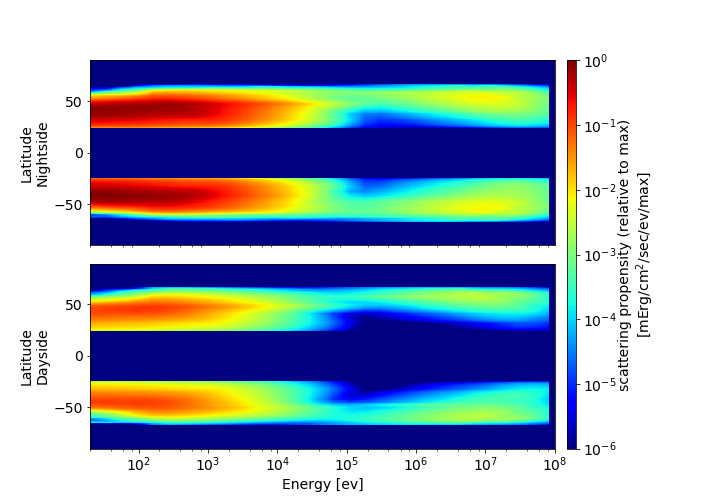

(360, 32)
(360, 256)
(360, 32)
(360, 256)
-100.0 -4.24150493841


In [31]:
# Find total spectrum vs latitude:
# Plot spectral density vs L-shell over the US:
flux_vs_lat = dict()

lonlims = [-50, 10]  # ~ approximately over the US
clims = [-6, 0]
left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

grid_E = []
for (p1, p2) in db['band_pairs']:
    grid_E.append((E[np.round((p1 + p2)/2)]))
#     print "fuck"

grid_E = np.array(grid_E)

print np.shape(pwr_maps_linear[0])
# print np.shape(gridlons), np.shape(gridFs), np.shape(gridLs)
for k in pwr_maps.keys():
    flux_vs_lat[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)
    flux_vs_lat[k] = np.log10(flux_vs_lat[k])
    flux_vs_lat[k][np.isinf(flux_vs_lat[k])] = -100

    
fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
cax = plt.subplot(gs[0:2,1])

# Find maximum value across all keys:
mv = -100
for k in flux_vs_lat.keys():
    if np.max(flux_vs_lat[k]) > mv:
        mv = np.max(flux_vs_lat[k])


for ind, k in enumerate(flux_vs_lat.keys()):
    # upsample for smoothness of plotting:
    print np.shape(flux_vs_lat[k])
    pinterp = interpolate.RegularGridInterpolator([gridlats, grid_E], flux_vs_lat[k] - mv, bounds_error=False, fill_value=-100)
    px, py = np.meshgrid(gridlats, E)
    pts = zip(px.ravel(), py.ravel())
    
    D_interp = pinterp(pts).reshape(len(E), len(gridlats)).T
    print np.shape(D_interp)
    
    p = ax[ind].pcolormesh(E, gridlats, D_interp, vmin = clims[0], vmax=clims[1], cmap = plt.get_cmap('jet'))
#     ax[ind].set_xlabel('Frequency [hz]')
#     ax[ind].set_ylabel('L shell')
print np.min(flux_vs_lat[k]), np.max(flux_vs_lat[k])
ax[0].set_xticks([])
ax[0].set_ylabel('Latitude\nNightside')
ax[-1].set_ylabel('Latitude\nDayside')
ax[-1].set_xlabel('Energy [ev]')

ax[0].set_xscale("log", nonposx='clip')
ax[1].set_xscale("log", nonposx='clip')


# Colorbar
cb = plt.colorbar(p, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
# cb.set_label('Flux spectral density [mErg/cm$^2$/sec/ev]') 
# cb.set_label('Normalized scattering propensity [max(#)/cm$^2$/sec/ev]') 
cb.set_label('scattering propensity (relative to max)\n[mErg/cm$^2$/sec/ev/max]') 


# ax[0].set_title('Global Average Lightning Spectra vs Field Line')

fig.subplots_adjust(right=0.8)
ax[0].set_xlim([2e1, 1e8])
ax[1].set_xlim([2e1, 1e8])

ax[0].set_xticks([])

fig.savefig('scattering_propensity_energy_vs_latitude.png',dpi=150)

In [366]:
for (p1, p2) in db['band_pairs']:
    print np.log10(E[p1]),np.log10(E[p2])
    

1.0 1.19215686275
1.19215686275 1.41176470588
1.41176470588 1.63137254902
1.63137254902 1.85098039216
1.85098039216 2.07058823529
2.07058823529 2.29019607843
2.29019607843 2.50980392157
2.50980392157 2.72941176471
2.72941176471 2.94901960784
2.94901960784 3.16862745098
3.16862745098 3.38823529412
3.38823529412 3.60784313725
3.60784313725 3.82745098039
3.82745098039 4.04705882353
4.04705882353 4.26666666667
4.26666666667 4.4862745098
4.4862745098 4.70588235294
4.70588235294 4.92549019608
4.92549019608 5.14509803922
5.14509803922 5.36470588235
5.36470588235 5.58431372549
5.58431372549 5.80392156863
5.80392156863 6.02352941176
6.02352941176 6.2431372549
6.2431372549 6.46274509804
6.46274509804 6.68235294118
6.68235294118 6.90196078431
6.90196078431 7.12156862745
7.12156862745 7.34117647059
7.34117647059 7.56078431373
7.56078431373 7.78039215686
7.78039215686 8.0


In [11]:
with gzip.open('/shared/users/asousa/WIPP/WIPP_stencils/outputs/stencils/nightside/stencil_30f_0.2L/kp0/phi_inlat_15_AE8MAX_flux_0.pklz','rb') as file:
    data = pickle.load(file)

In [12]:
E = data['params']['E_tot_arr']

<IPython.core.display.Javascript object>


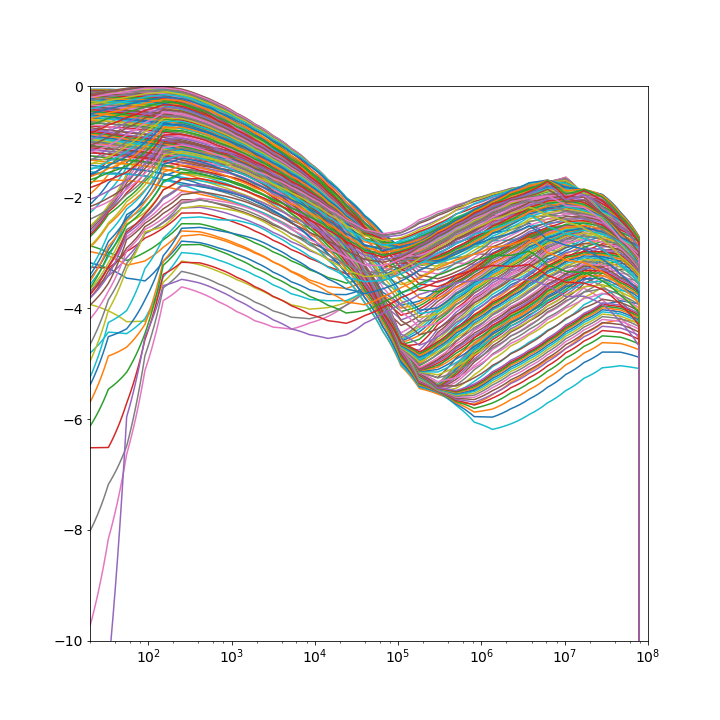

(20, 100000000.0)

In [382]:
fig, ax = plt.subplots(1,1)
ax.plot(E, D_interp[:,:].T)
ax.set_ylim([-10,0])
ax.set_xscale("log", nonposx='clip')
ax.set_xlim([20,1e8])




<IPython.core.display.Javascript object>


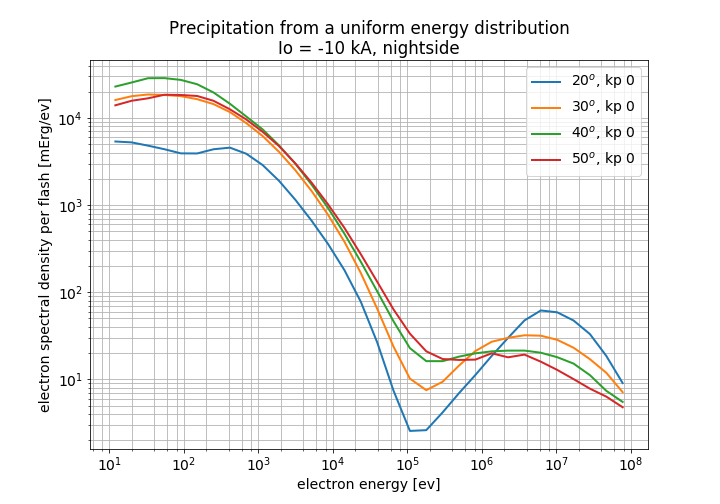

In [29]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# Plot total particles per energy band, per a single flash stencil:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(np.arange(-90, 90, 0.5)) + dlat/2.0)*D2R))


def tern(arg, a, b):
    ''' how the fuck does Python not have a native terniary operator '''
    if arg:
        return a
    else:
        return b
        


kps = [0]
mlts = [0]
Io = -10e3

inlats = [20, 30, 40, 50] #[15, 25, 35, 45, 55]
band = 0


fig, ax = plt.subplots(1,1)
for kp in kps:
    for mlt in mlts:
        for inlat in inlats:
            key = (int(10.*kp),inlat, mlt)

            d = precalc_stencils[key]*pow(Io, 2)
            spec = np.sum(np.sum((d*cell_areas[:,np.newaxis, np.newaxis]),axis=0), axis=0)
            ax.loglog(grid_E, spec, label='%d$^o$, kp %d'%(inlat, kp), linestyle=tern(mlt==0,'solid','dashed'), linewidth=2)

ax.legend()
ax.grid('on', which='both')
ax.set_ylabel('electron spectral density per flash [mErg/ev]')
ax.set_xlabel('electron energy [ev]')

ax.set_title('Precipitation from a uniform energy distribution\nIo = %d kA, nightside'%(Io*1e-3))
fig.savefig('energy_spectrum_vs_input_lat.png',dpi=150)
# # d = precalc_stencils[key][:,:,band]/np.max(precalc_stencils[key])
# ax.pcolormesh(stencil_lons, stencil_lats, np.log10(spec), vmin=-3, vmax=0)

